# Inference demo

This notebook walks you through the main steps of running inference on a single PROTECT model

In [8]:
import arviz as az, numpy as np, numpyro
numpyro.set_host_device_count(8)
import pandas as pd
from jax import numpy as jnp, random;
rng_key = random.PRNGKey(0)
from protect.models import PROTECTModel
from protect.inference import PROTECTInference
from protect.utils import load_yaml
from protect.utils import summary_likelihoods_to_df, model_check_evaluation_to_df, summarize_data

In [10]:
# read the simulated data
data_pd = pd.read_csv("data1000.csv")
data = {k: np.array(v) for k, v in data_pd.items()}
pd.DataFrame(summarize_data(data))

,shapes,dims,means,stds,nas,dtypes
age,"(1000,)",1,-0.028320,1.002480,0,float64
proxy1,"(1000,)",1,0.156000,0.362855,0,int64
proxy2,"(1000,)",1,0.652000,0.476336,0,int64
y,"(1000,)",1,3.721249,3.530017,0,float64
tx,"(1000,)",1,0.716000,0.450937,0,int64
time_cens,"(1000,)",1,0.081249,5.128559,0,float64
deceased,"(1000,)",1,0.818000,0.385845,0,bool


In [3]:
from model import tutorial_model as mymodel
metadata = load_yaml('metadata.yaml')

model = PROTECTModel(mymodel, metadata, prior_spec="priors.csv", data=data)
model.check_data(data)


True

In [4]:
# run the model forward once with a random seed
output = model.sample(123,data)

# create protector object
protector = PROTECTInference(model, data)

In [5]:
# run inference on original data
rng_key, k_mcmc = random.split(rng_key)
samples = protector.run_inference(k_mcmc,
                                  mcmc_kwargs={'num_samples': 500, 'num_warmup': 100, 'num_chains': 4,
                                               'chain_method': 'parallel', 'progress_bar': False},)
protector.get_summary()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_tx,-0.484,0.199,-0.890,-0.120,0.006,0.004,916.0,488.0,1.0
mu_proxy1,-0.160,0.282,-0.709,0.411,0.009,0.006,1032.0,1321.0,1.0
mu_proxy2,-2.941,0.360,-3.696,-2.284,0.013,0.008,765.0,1173.0,1.0
b_tx_y,-0.102,0.132,-0.344,0.159,0.003,0.002,1804.0,1541.0,1.0
b_F_proxy1,-4.455,0.751,-5.860,-2.924,0.024,0.017,976.0,1289.0,1.0
b_F_proxy2,-4.275,0.616,-5.522,-3.169,0.022,0.014,743.0,1236.0,1.0
b_F_tx,0.898,0.389,0.140,1.651,0.013,0.009,819.0,428.0,1.0
b_F_y,-1.349,0.255,-1.826,-0.830,0.008,0.006,1119.0,1193.0,1.0
b_Ftx_y,0.112,0.209,-0.308,0.498,0.005,0.004,2107.0,1488.0,1.0
b_age_F,-0.837,0.099,-1.032,-0.658,0.003,0.002,1103.0,1528.0,1.0


### Potentially save samples for later use

In [ ]:
# samples_by_chain = protector.get_samples(group_by_chain=True)
# azd_globals = az.from_dict({k: v for k, v in samples_by_chain.items() if k in model.global_prms})
# azd_globals.to_netcdf("global_samples.nc")

## Perform PROTECT model checks

In [6]:
rng_key, k_modelcheck = random.split(rng_key, 2)
# setting num_folds = 2 and num_global_samples = 10 for speed; defaults (num_folds=5, num_global_samples=1000) are better values
model_check_results, _ = protector.model_checks(k_modelcheck, num_folds=2, num_global_samples=10)
# summarize the model checks
model_check_evaluation = protector.protect_model.model_check_evaluation(model_check_results)
print(f"all checks passed: {model_check_evaluation['all_passed']}")
model_check_df = model_check_evaluation_to_df(model_check_evaluation)
model_check_df

ValueError: compiling computation that requires 8 logical devices, but only 5 XLA devices are available (num_replicas=8)

## Calculate marginalized hazard ratio for model

The default outcome model in protect is a power generalized weibull (PGW) model.
The treatment parameter is a hazard ratio.
Because the hazard ratio is non-collapsible, we need to marginalize it over the population in order to compare it to a marginal hazard ratio from a (hypothetical) randomized trial.
This needs to be done for every sample of the posterior distribution over parameters to get a distribution over the marginalized hazard ratio.

For the PGW model, there is an inbuilt method to do this.
For other non-collapsible outcome models (e.g. other non-collapsible survival models, logistic regresion, ...), you will need to run `protect.run_postpred_mcmc` with `pp_mode="no_txy"` to get samples from the predictive distribution that includes the local (latent) parameter.
From this you can simulate outcomes under hypothetical RCTs conditional on the parameter estimate, where you should simulate outcomes for two copies of the data: one with treatment set to 0 and one with treatment set to 1.
For each sample, analyze the data as you would in a real RCT, e.g. a Cox proportional hazards model or a logistic regression model.
This will give you a posterior distribution over the marginalized effect parameter.


In [ ]:
rng_key, rng_marginalization = random.split(rng_key)
marg_results = protector.get_marginalized_hazard_ratio(
    rng_marginalization, samples
)

In [ ]:
marginal_hr = marg_results['params'][:,1]
converged = marg_results['converged']
assert (converged).all(), "Not all samples converged"
print(f"max iterations needed: {marg_results['i'].max()}")
print(f"{marginal_hr.mean()=:.3f} with std {marginal_hr.std():.3f}")


max iterations needed: 3
marginal_hr.mean()=-0.041 with std 0.091


/var/folders/lz/l2_06bbx7fn4z318dtwnb3x40000gp/T/ipykernel_14855/1875183064.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


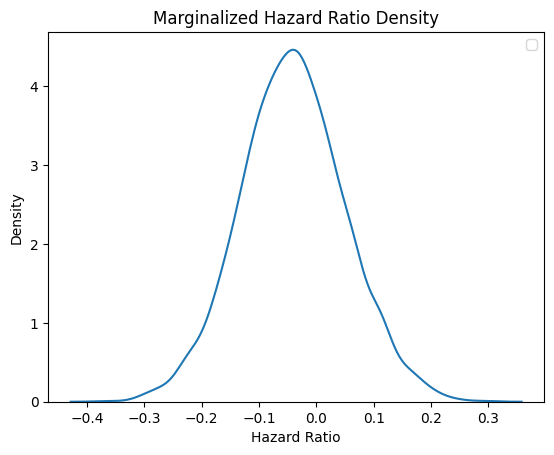

In [ ]:
# plot density of marginal_hr for those that have converged
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(marginal_hr)

# add strip plot for non-converged values
# non_conv_hr = marginal_hr[non_converged_iis]
# sns.stripplot(x=non_conv_hr, color='red', label='non-converged', alpha=0.5)
plt.legend()
plt.title('Marginalized Hazard Ratio Density')
plt.xlabel('Hazard Ratio')
plt.ylabel('Density')
plt.show()


## Plot survival curves for average outcomes

The better way to approach this is to estimate survival curves for every posterior sample, and then average the curves.
The current approach averages survival times per patient and then plots the survival curve for the expected survival time per patient.




In [ ]:
et0 = marg_results['time0'].mean(axis=0)
et1 = marg_results['time1'].mean(axis=0)

e0 = et0 > 0
t0 = jnp.abs(et0)
e1 = et1 > 0
t1 = jnp.abs(et1)


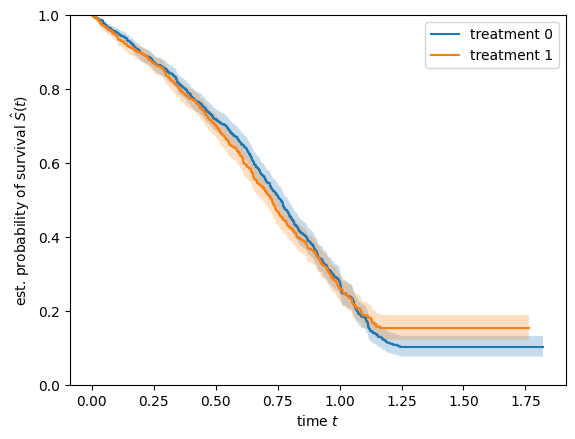

In [ ]:
from sksurv.nonparametric import kaplan_meier_estimator
from matplotlib import pyplot as plt

tt0, s0, ci0 = kaplan_meier_estimator(e0, t0, conf_type="log-log")
tt1, s1, ci1 = kaplan_meier_estimator(e1, t1, conf_type="log-log")

plt.step(tt0, s0, where="post", label="treatment 0")
plt.fill_between(tt0, ci0[0], ci0[1], alpha=0.25, step="post")
plt.step(tt1, s1, where="post", label="treatment 1")
plt.fill_between(tt1, ci1[0], ci1[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

## Evaluate predictive performance

We evaluate Harrell's c-index to assess discrimatory performance of the model.
For this, we need to get posterior predictive samples.
These can either condition on all variables except survival (`pp_mode='no_y'`),
or on all variables except survival **and** treatment, which would mimic predicting survival under hypothetical treatment or no treatment (like in an RCT) (`pp_mode='no_txy'`).


In [ ]:
smps_no_y = protector.run_postpred_mcmc(random.PRNGKey(7), samples, pp_mode="no_y", num_local_draws=100)
smps_no_txy = protector.run_postpred_mcmc(random.PRNGKey(7), samples, pp_mode="no_txy", num_local_draws=100)

In [ ]:
c_index_no_y = protector.get_c_index(pp_mode="no_y", posterior_samples=smps_no_y)
c_index_no_txy = protector.get_c_index(pp_mode="no_txy", posterior_samples=smps_no_txy)

print(f"c index (95% CI) for no_y: {c_index_no_y.mean():.3f}, ({az.hdi(np.array(c_index_no_y))})")
print(f"c index (95% CI) for no_txy: {c_index_no_txy.mean():.3f}, ({az.hdi(np.array(c_index_no_txy))})")

c index (95% CI) for no_y: 0.550, ([0.5346854  0.55810225])
c index (95% CI) for no_txy: 0.548, ([0.53445554 0.55731446])


We can also evaluate how good the model is in predicting treatment (with or without conditioning on survival). For this we calculate the AUC.

In [ ]:
smps_no_tx = protector.run_postpred_mcmc(rng_key, pp_mode="no_tx", posterior_samples=samples)

In [ ]:
auc_no_tx = protector.get_treatment_auc(pp_mode="no_tx", posterior_samples=smps_no_tx)
auc_no_txy = protector.get_treatment_auc(pp_mode="no_txy", posterior_samples=smps_no_txy)
print(f"auc for predicting treatment (95% CI) for no_tx: {auc_no_tx.mean():.3f}, ({az.hdi(np.array(auc_no_tx))})")
print(f"auc for predicting treatment (95% CI) for no_txy: {auc_no_txy.mean():.3f}, ({az.hdi(np.array(auc_no_txy))})")

auc for predicting treatment (95% CI) for no_tx: 0.538, ([0.5149845  0.55853134])
auc for predicting treatment (95% CI) for no_txy: 0.532, ([0.5082717  0.55700195])
